#### This notebook demonstrates what runs on the backend. 

NOTE--color quantization performed according to scikit-learn docs: https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

#### Read image to a numpy array
We use PIL, the Python Imaging Library, in order to read the image from either a filepath (or from a request in the backend)

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import pandas as pd

def loadImage(fname: str, size: int) -> np.ndarray:
    # This function accepts a filename and a size, returning a NumPy array of shape (W, H, 3)
    # containing the RGB value for each pixel
    im = Image.open(fname) # create PIL image
    im.thumbnail([size,size], Image.LANCZOS) # resize
    return np.asarray(im) # read into numpy array and return

imageArray = loadImage("images/Bird.jpg", 40)


#### Train image on Mini-batch K-means

We use mini batch K-means as it's faster and we're working with relatively small amounts of data. This will ensure the model runs quicker on the backend and serve a result to the user quicker.

In [3]:
def train(data: np.ndarray, w: int, h: int, k: int):
    # accepts image array returned by loadImage, width and height of image, and k--the number of clusters
    # returns the codebook for the model and a 1d array of labels (indices into the codebook for each pixel)
    flattened = np.reshape(data, (w*h, 3))
    kmeans = MiniBatchKMeans(n_clusters = k, n_init = 'auto', random_state = 0)
    kmeans.fit(flattened)
    return [kmeans.cluster_centers_, kmeans.predict(flattened)]

w, h, d = imageArray.shape # get width and height of image

palette, labels = train(imageArray, w, h, 5) 

#### Image reconstruction

In [5]:
def convertPaletteToDMC(palette, dmc_url):
    """
    ARGS:
    palette: array-like of cluster centers
    dmc_url: url containing dataset of floss colors
    PURPOSE:
    This function accepts a palette (codebook) and converts it into 
    RGB colors that represent DMC floss.
    It returns a list of two items, the first is a typical codebook
    The second is a list consisting of pairs of RGB colors and DMC ids, used for the legend
    """
    dmc_df = pd.read_csv(dmc_url, header = None)
    dmc_colors = [resolvePixel(pix, dmc_df) for pix in palette]
    rgb = [x[0] for x in dmc_colors]
    return [np.asarray(rgb), dmc_colors]
    
def resolvePixel(pixel, df):
    """
    ARGS:
    pixel: array of length 3 containing rgb values for a pixel you want to map to a DMC color
    df: pandas DataFrame containing DMC floss and their RGB values. expects columns 2-4 to be RGB, last col to be color description
    PURPOSE:
    Computes which dmc color is the closest in terms of euclidean distance (plot rgb values on 3d grid, pick the closest)
    """
    bestDist = 99999 # initialize distance to some large number
    bestColor = -1   # initialize color to some dummy value
    bestID = -1
    for color in df.iterrows():
        dist = np.sqrt(np.sum((pixel-color[1][1:-1])**2)) # compute euclidean distance between DMC color and pixel
        if dist < bestDist: # if it does better, update
            bestDist = dist
            bestColor = color[1][1:-1]
            bestID = color[1][0]
    return [np.asarray(bestColor), bestID] # rgb and dmc id

def gen_image(palette, labels, w, h):
    return palette[labels].reshape(w, h, -1) # -1 means infer third dimension (should be 3)


palette, colors = convertPaletteToDMC(palette, "dmc.csv")
colors = [[x[0] / 255, x[1]] for x in colors]

finalImageArray = gen_image(palette, labels, w, h).astype(np.uint8) # convert floats to uint8 for PIL
finalImage = Image.fromarray(finalImageArray) # create PIL image from output array
                                    

#### Generate pattern pdf

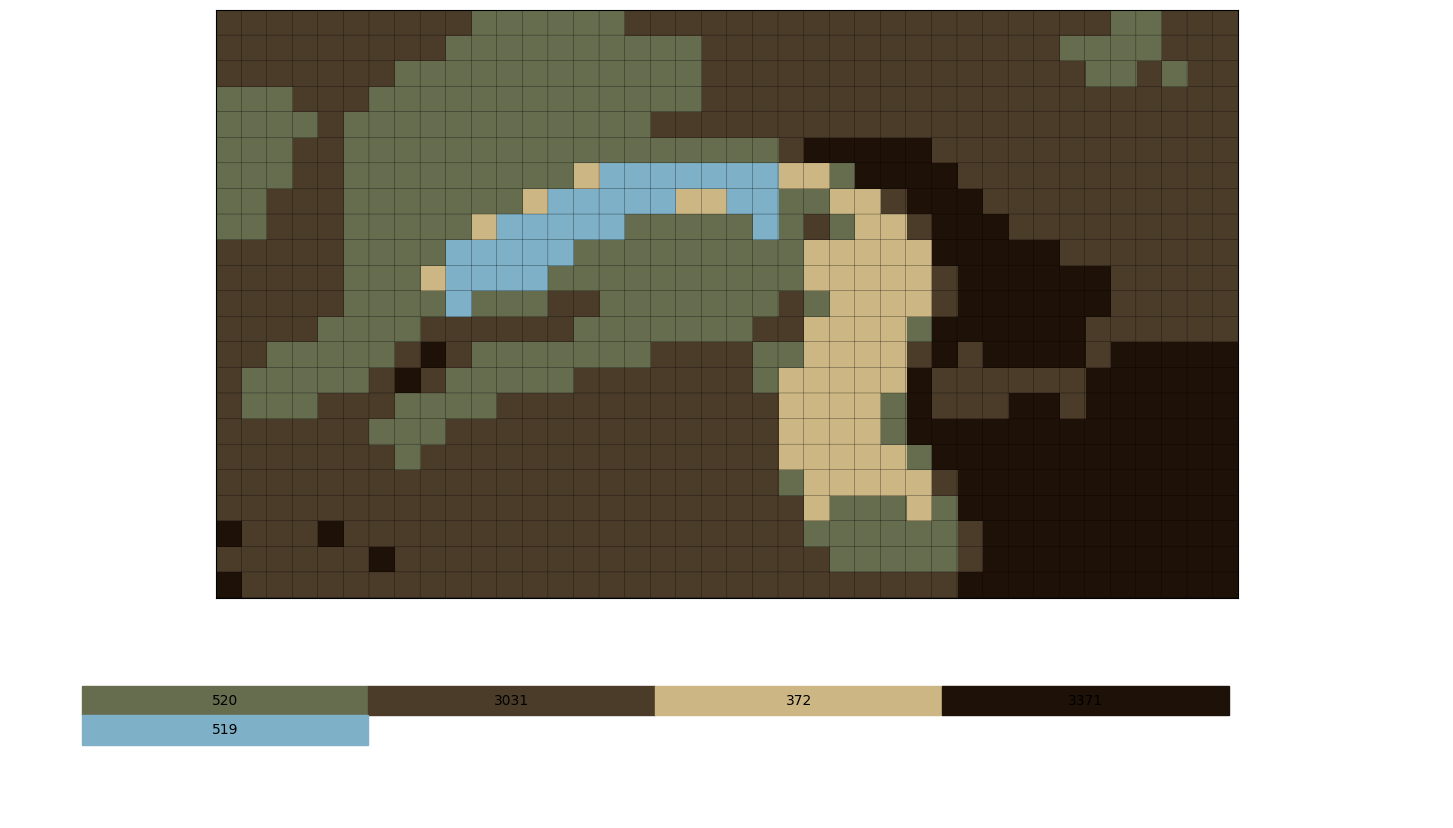

In [6]:
from matplotlib.patches import Rectangle

fig, (imAxis, colorAxis) = plt.subplots(2, 1, height_ratios=[4,1]) # create figure

imAxis.imshow(finalImage, extent=[0, finalImage.width, 0, finalImage.height], snap=False) # add image to subplot
imAxis.set_xticks([x for x in range(finalImage.width)]) # set ticks at one pixel intervals
imAxis.set_yticks([y for y in range(finalImage.height)]) 
imAxis.grid(color='black', linestyle='-', linewidth=0.2, snap=False) # add grid

imAxis.set_xticklabels([]) # remove tick labels
imAxis.set_yticklabels([])
imAxis.tick_params(axis='both', which='both', length=0) # remove ticks

# define the position and size of the colorbar
bar_height = 0.2
bar_left = 0.05
bar_bottom = 0.7
row_size = 4

# create a rectangle for each color and add it to the plot
for i, (rgb, name) in enumerate(colors):
    row = i // row_size
    column = i % row_size
    rect = Rectangle((bar_left + column*bar_height, bar_bottom - row*bar_height), bar_height, bar_height, color=rgb)
    colorAxis.add_patch(rect)
    colorAxis.text(bar_left + column*bar_height + bar_height/2, bar_bottom + bar_height/2 - row*bar_height, name, ha='center', va='center')

# hide the axis and show the plot
colorAxis.set_axis_off()

fig.set_size_inches(18.5, 10.5)

fig.savefig("output.pdf")